### Import Packages

In [481]:
import os
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
from scipy import stats
from copy import copy
import numpy as np
import logging
import pandas as pd
from scipy import signal
import scipy

logging.basicConfig(filename='analysis_tools.log',filemode='w',level=logging.DEBUG)
#logging.basicConfig(level=logging.INFO)

## Main Analysis Functions

In [828]:
# function for loading all audio clips in a directory
def load_audio_clips(audio_fpath):
    #initialize list for holding audio clips
    audio_clips = []
    ext = '.ogg'
    #recursively load audio, assuming all files in directory are audio files
    for root,dirs,files in os.walk(audio_fpath):
        for name in files:
            if name[-4:] == ext:
                audio_clips.append(root+'/'+name)
        #logging.info('%i audio file(s) in %s have been loaded.'%(len(files),root))
    return audio_clips


def librosa_load_both(audio_clip,sr=32000,window='tukey',alpha=0.5,n_fft=2048):
    #librosa takes audio clip path and loads it as a waveform array
    #all audio files in our study are down sampled to 32000 Hz
    x, sr = librosa.load(audio_clip,sr=sr)
    
    #use window function to prevent spectral leakage
    if window == 'tukey':
        window_func = signal.windows.tukey(x.shape[0],alpha)
    else:
        window_func = 1
    x *= window_func
    
    #librosa's short time ft
    X = librosa.stft(x,n_fft=n_fft)
    freqs = np.arange(0, 1 + n_fft / 2) * sr / n_fft
    return x, X, sr, freqs

def wave_fourier_display(x_wave,X_fft,sr):
    #x, sr = librosa.load(audio_clip,sr=sr)
    plt.figure(figsize=(20,8))
    plt.subplot(121)
    librosa.display.waveplot(x_wave,sr)
    #X = librosa.stft(x*window)
    plt.subplot(122)
    Xdb = librosa.amplitude_to_db(abs(X_fft))
    librosa.display.specshow(Xdb,sr=sr,x_axis='time',y_axis='log')
    plt.colorbar(label='Amplitude (db)')
    plt.show()
    
def plot_PSD(X_fft,freqs,sr=32000): 
    Xcov = np.cov(X_fft)
    psd = np.sqrt(np.abs(np.diag(Xcov)))
    plt.figure(figsize=(20,8))
    plt.subplot(121)
    plt.plot(freqs,psd,'k')
    plt.subplot(122)
    Xcovdb = librosa.amplitude_to_db(np.abs(Xcov)/np.mean(np.diag(np.abs(Xcov))))
    librosa.display.specshow(Xcovdb,sr=sr,x_axis='log',y_axis='log')
    plt.show()
    
    
    
def plot_compare_PSD(X_fft1,X_fft2,freqs):
    Xcov1 = np.cov(X_fft1)
    psd1 = np.sqrt(np.abs(np.diag(Xcov1)))
    Xcov2 = np.cov(X_fft2)
    psd2 = np.sqrt(np.abs(np.diag(Xcov2)))
    plt.figure(figsize=(20,8))
    plt.plot(freqs,psd1,'k')
    plt.plot(freqs,psd2,'r--')
    #plt.xscale('log')
    plt.show()
    
def compute_psd_params(X_fft):
    Xcov = np.cov(X_fft)
    psd = np.sqrt(np.abs(np.diag(Xcov)))
    psd_mean = np.mean(psd)
    psd_var = np.std(psd)
    return psd, psd_mean, psd_var
    
def plot_phases(X_fft,freqs,sr=32000):
    phase_pos = int(X_fft.shape[0]/2)
    phases = np.angle(X_fft[:,1]).copy()
    plt.figure(figsize=(20,8))
    plt.scatter(freqs,phases)
    #plt.xscale('log')
    plt.show()

def whiten_invert(X_fft):
    # estimate covariance matrix
    Xcov = np.cov(X_fft)
    # find power spectral density
    psd = np.sqrt(np.abs(np.diag(Xcov)))
    
    X_noise_norm = X_fft.copy()
    for i in range(len(psd)):
        X_noise_norm[i,:] *= psd[i]/np.mean(psd)
        
    x_wave = librosa.istft(X_noise_norm)
    return x_wave,X_noise_norm,sr

def whiten_invert_2(X_fft,ntype='thresh_spec',threshold=3):
    # estimate covariance matrix
    Xcov = np.cov(X_fft)
    # find power spectral density
    psd = np.sqrt(np.abs(np.diag(Xcov)))
    X_noise_norm = X_fft.copy()
    
    if ntype=='spec':
        for i in range(len(psd)):
            X_noise_norm[i,:] /= psd[i]
    elif ntype=='mean':
        X_noise_norm /= np.mean(psd)
    elif ntype=='thresh_spec':
        for i in range(len(psd)):
            if psd[i] < np.mean(psd) + threshold * np.std(psd):
                X_noise_norm[i,:] /= psd[i]
    elif ntype=='thresh_amp':
        X_noise_norm /= np.mean(psd)
        for i in range(len(psd)):
            if psd[i] > np.mean(psd) + threshold * np.std(psd):
                X_noise_norm[i,:] *= psd[i]*np.mean(psd)
        
    x_wave = librosa.istft(X_noise_norm)
    return x_wave,X_noise_norm,sr

def list_birds(metadata_path):
    df = pd.read_csv(metadata_path)
    bird_list = df['primary_label'].drop_duplicates()
    return bird_list

def gen_psd_list(audio_clips):
    psd_list = []
    widths = np.logspace(4,12,base=2)
    cwt_mat_list = []
    for clip in audio_clips:
        x, X, sr, freqs = librosa_load_both(clip,alpha=0.1)
        psd,psdm,psdv = compute_psd_params(X)
        psd_list.append(psd/psdv)
    return psd_list

def sig_peak_finder_internal(input_signal,freqs,primary_widths=[1,200],prominence_limit=0.1,n_peaks=5):
    input_signal_var = np.std(input_signal)
    peaks,peak_features= signal.find_peaks(input_signal/input_signal_var,width=[1,200],prominence=prominence_limit)
    peak_features['indexes'] = peaks
    peak_features['frequency'] = freqs[peaks]
    df = pd.DataFrame(peak_features)
    top_peaks = df.sort_values(df.columns[0],ascending=False,axis=0).head(n_peaks).reset_index()
    feature_dict = {}
    iter_freq = []
    iter_prom = []
    iter_width = []
    iter_acc = []
    iter_index = []
    iter_wh = []
    iterable_features = {}
    
    for index,peak in top_peaks.iterrows():
        ipsd = peak['indexes']
        secondary_width = peak['widths']
        lower_limit = max([0,int(ipsd-secondary_width)])
        upper_limit = min([int(ipsd+secondary_width+1)])
        sig_window = psd[lower_limit:upper_limit]/input_signal_var
        peaks = signal.find_peaks_cwt(sig_window,widths=np.arange(1,int(secondary_width+1)),wavelet=signal.ricker)+lower_limit
        acc_check = pd.Series([(np.abs(peaks-ipsd))/secondary_width,0]).explode().values
        accuracy = 1 - min(acc_check)
        
        label_freq = 'peak%i_freqency'%index
        label_prom = 'peak%i_prominence'%index
        label_width = 'peak%i_width'%index
        label_acc = 'peak%i_accuracy'%index
        label_index = 'peak%i_index'%index
        label_wh = 'peak%s_width_height'%index
        
        feature_dict[label_freq] = peak['frequency']
        feature_dict[label_prom] = peak['prominences']
        feature_dict[label_width] = secondary_width
        feature_dict[label_acc] = accuracy
        #feature_dict[label_index] = int(ipsd)
        feature_dict[label_wh] = peak['width_heights']
        
        iter_freq.append(peak['frequency'])
        iter_prom.append(peak['prominences'])
        iter_width.append(secondary_width)
        iter_acc.append(accuracy)
        iter_index.append(int(ipsd))
        iter_wh.append(peak['width_heights'])
        
    iterable_features['frequencies'] = iter_freq
    iterable_features['prominences'] = iter_prom
    iterable_features['widths'] = iter_width
    iterable_features['accuracies'] = iter_acc
    iterable_features['indexes'] = iter_index
    iterable_features['width_heights'] = iter_wh
        
    return feature_dict,iterable_features


def sig_peak_finder(input_signal,freqs,primary_widths=[1,200],prominence_limit=0.1,n_peaks=5,label_prefix='peak',extend_label=False,extension='_autocorr'):
    input_signal_var = np.std(input_signal)
    peaks,peak_features= signal.find_peaks(input_signal/input_signal_var,width=[1,200],prominence=prominence_limit)
    peak_features['indexes'] = peaks
    peak_features['frequency'] = freqs[peaks]
    df = pd.DataFrame(peak_features)
    top_peaks = df.sort_values(df.columns[0],ascending=False,axis=0).head(n_peaks).reset_index()
    feature_dict = {}
    
    for index,peak in top_peaks.iterrows():
        ipsd = peak['indexes']
        secondary_width = peak['widths']
        lower_limit = max([0,int(ipsd-secondary_width)])
        upper_limit = min([int(ipsd+secondary_width+1)])
        sig_window = psd[lower_limit:upper_limit]/input_signal_var
        peaks = signal.find_peaks_cwt(sig_window,widths=np.arange(1,int(secondary_width+1)),wavelet=signal.ricker)+lower_limit
        acc_check = pd.Series([(np.abs(peaks-ipsd))/secondary_width,0]).explode().values
        accuracy = 1 - min(acc_check)
        
        s_index = label_prefix+str(index)
        if extend_label: s_index+=extension
        
        label_freq = '%s_freqency'%s_index
        label_prom = '%s_prominence'%s_index
        label_width = '%s_width'%s_index
        label_acc = '%s_accuracy'%s_index
        label_index = '%s_index'%s_index
        label_wh = '%s_width_height'%s_index
        
        feature_dict[label_freq] = peak['frequency']
        feature_dict[label_prom] = peak['prominences']
        feature_dict[label_width] = secondary_width
        feature_dict[label_acc] = accuracy
        #feature_dict[label_index] = int(ipsd)
        feature_dict[label_wh] = peak['width_heights']
        
    return feature_dict


def output_spectral_peaks(audio_clip,n_peaks_primary=5,n_peaks_secondary=3):
    x,X,sr,freqs = librosa_load_both(audio_clip,alpha=0.1)
    psd,psdm,psdv = compute_psd_params(X)
    final_dict = {}
    features_dict,iter_feat = sig_peak_finder_internal(psd,freqs,n_peaks=n_peaks_primary)
    final_dict.update(features_dict.copy())
    Xcov = np.cov(X)
    for index,peak_index in enumerate(iter_feat['indexes']):
        autocorr_col = np.abs(Xcov[peak_index,:])/psdv
        label_prefix = 'peak%s_autocorr'%str(index)
        autocorr_features = sig_peak_finder(autocorr_col,freqs,label_prefix=label_prefix,n_peaks=n_peaks_secondary)
        final_dict.update(autocorr_features)
    return final_dict

def short_audio_features_main(metadata_path,audio_fpath_short,savedir):
    bird_list = list_birds(metadata_path)
    df = pd.read_csv(metadata_path)
    features_df = pd.DataFrame(data=None)
    i = 0
    for bird_name in bird_list:
        features_df = pd.DataFrame(data=None)
        sub_df = df.loc[df['primary_label']==bird_name]
        target = {}
        target['primary_label'] = bird_name
        bird_path=audio_fpath_short+bird_name
        print(bird_path)
        audio_clip = load_audio_clips(bird_path)
        for clip in audio_clips:
            features_dict = output_spectral_peaks(clip)
            final_dict = {**features_dict.copy(),**target.copy()}
            features_df = features_df.append(final_dict,ignore_index=True)
        features_df.to_csv('{}{}_peak_features.csv'.format(savedir,bird_name))
    

In [ ]:

mp = '../Bird Data/train_metadata.csv'
aps = '../Bird Data/train_short_audio/'
savedir = '../Bird Data/'
short_audio_features_main(mp,aps,savedir)

../Bird Data/train_short_audio/acafly
../Bird Data/train_short_audio/acowoo
../Bird Data/train_short_audio/aldfly
../Bird Data/train_short_audio/ameavo
../Bird Data/train_short_audio/amecro
../Bird Data/train_short_audio/amegfi
../Bird Data/train_short_audio/amekes
../Bird Data/train_short_audio/amepip
../Bird Data/train_short_audio/amered
../Bird Data/train_short_audio/amerob
../Bird Data/train_short_audio/amewig
../Bird Data/train_short_audio/amtspa
../Bird Data/train_short_audio/andsol1
../Bird Data/train_short_audio/annhum
../Bird Data/train_short_audio/astfly
../Bird Data/train_short_audio/azaspi1
../Bird Data/train_short_audio/babwar
../Bird Data/train_short_audio/baleag
../Bird Data/train_short_audio/balori
../Bird Data/train_short_audio/banana


In [483]:
metadata_path = '../Bird Data/train_metadata.csv'
bird_list = list_birds(metadata_path)

In [484]:
audio_fpath_long = '../Bird Data/train_soundscapes/'
audio_fpath_short = '../Bird Data/train_short_audio/'

In [485]:
audio_clips = load_audio_clips(audio_fpath_short+bird_list[0])

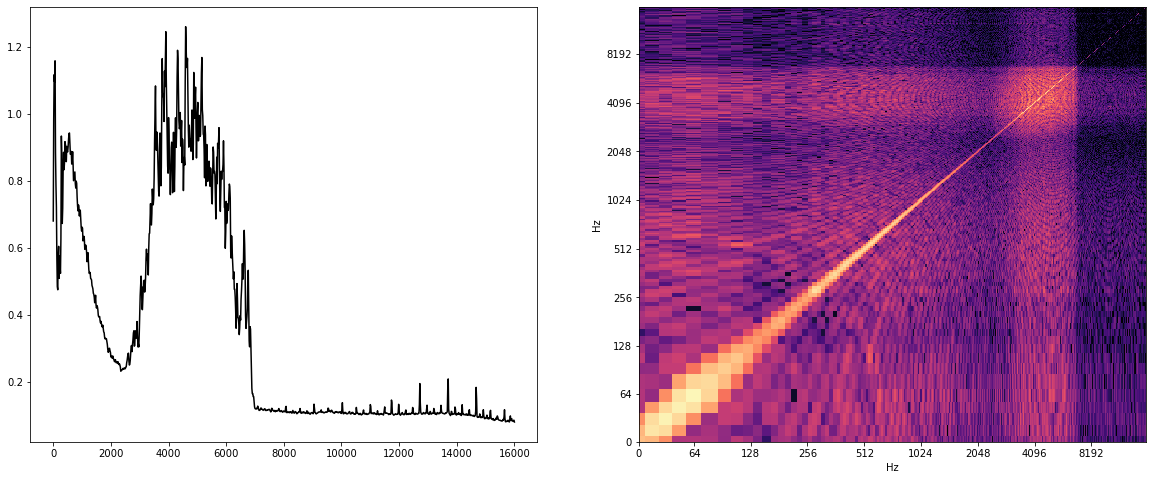

In [745]:
x,X,sr,freqs = librosa_load_both(audio_clips[4],alpha=0.1)
plot_PSD(X,freqs)

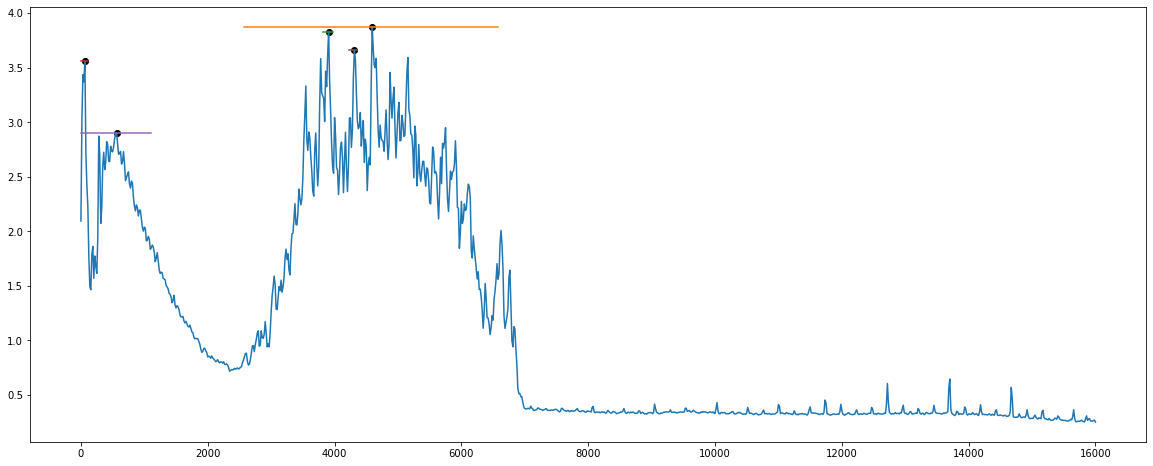

In [744]:
x,X,sr,freqs = librosa_load_both(audio_clips[4],alpha=0.1)
psd,psdm,psdv = compute_psd_params(X)
features_dict,iter_feat = sig_peak_finder_internal(psd,freqs)
plt.figure(figsize=(20,8))
plt.plot(freqs,psd/psdv)
plt.scatter(iter_feat['frequencies'],psd[iter_feat['indexes']]/psdv,c='k')
for i in np.arange(len(iter_feat['frequencies'])):
    peak_width = iter_feat['widths'][i]
    peak_index = iter_feat['indexes'][i]
    freq_range = np.arange(int(max(peak_index-peak_width,0)),int(min(len(freqs),peak_index+peak_width)))
    peak_width_freqs = freqs[freq_range]
    peak_width_line = np.ones(len(peak_width_freqs))*psd[iter_feat['indexes'][i]]/psdv
    plt.plot(peak_width_freqs,peak_width_line)

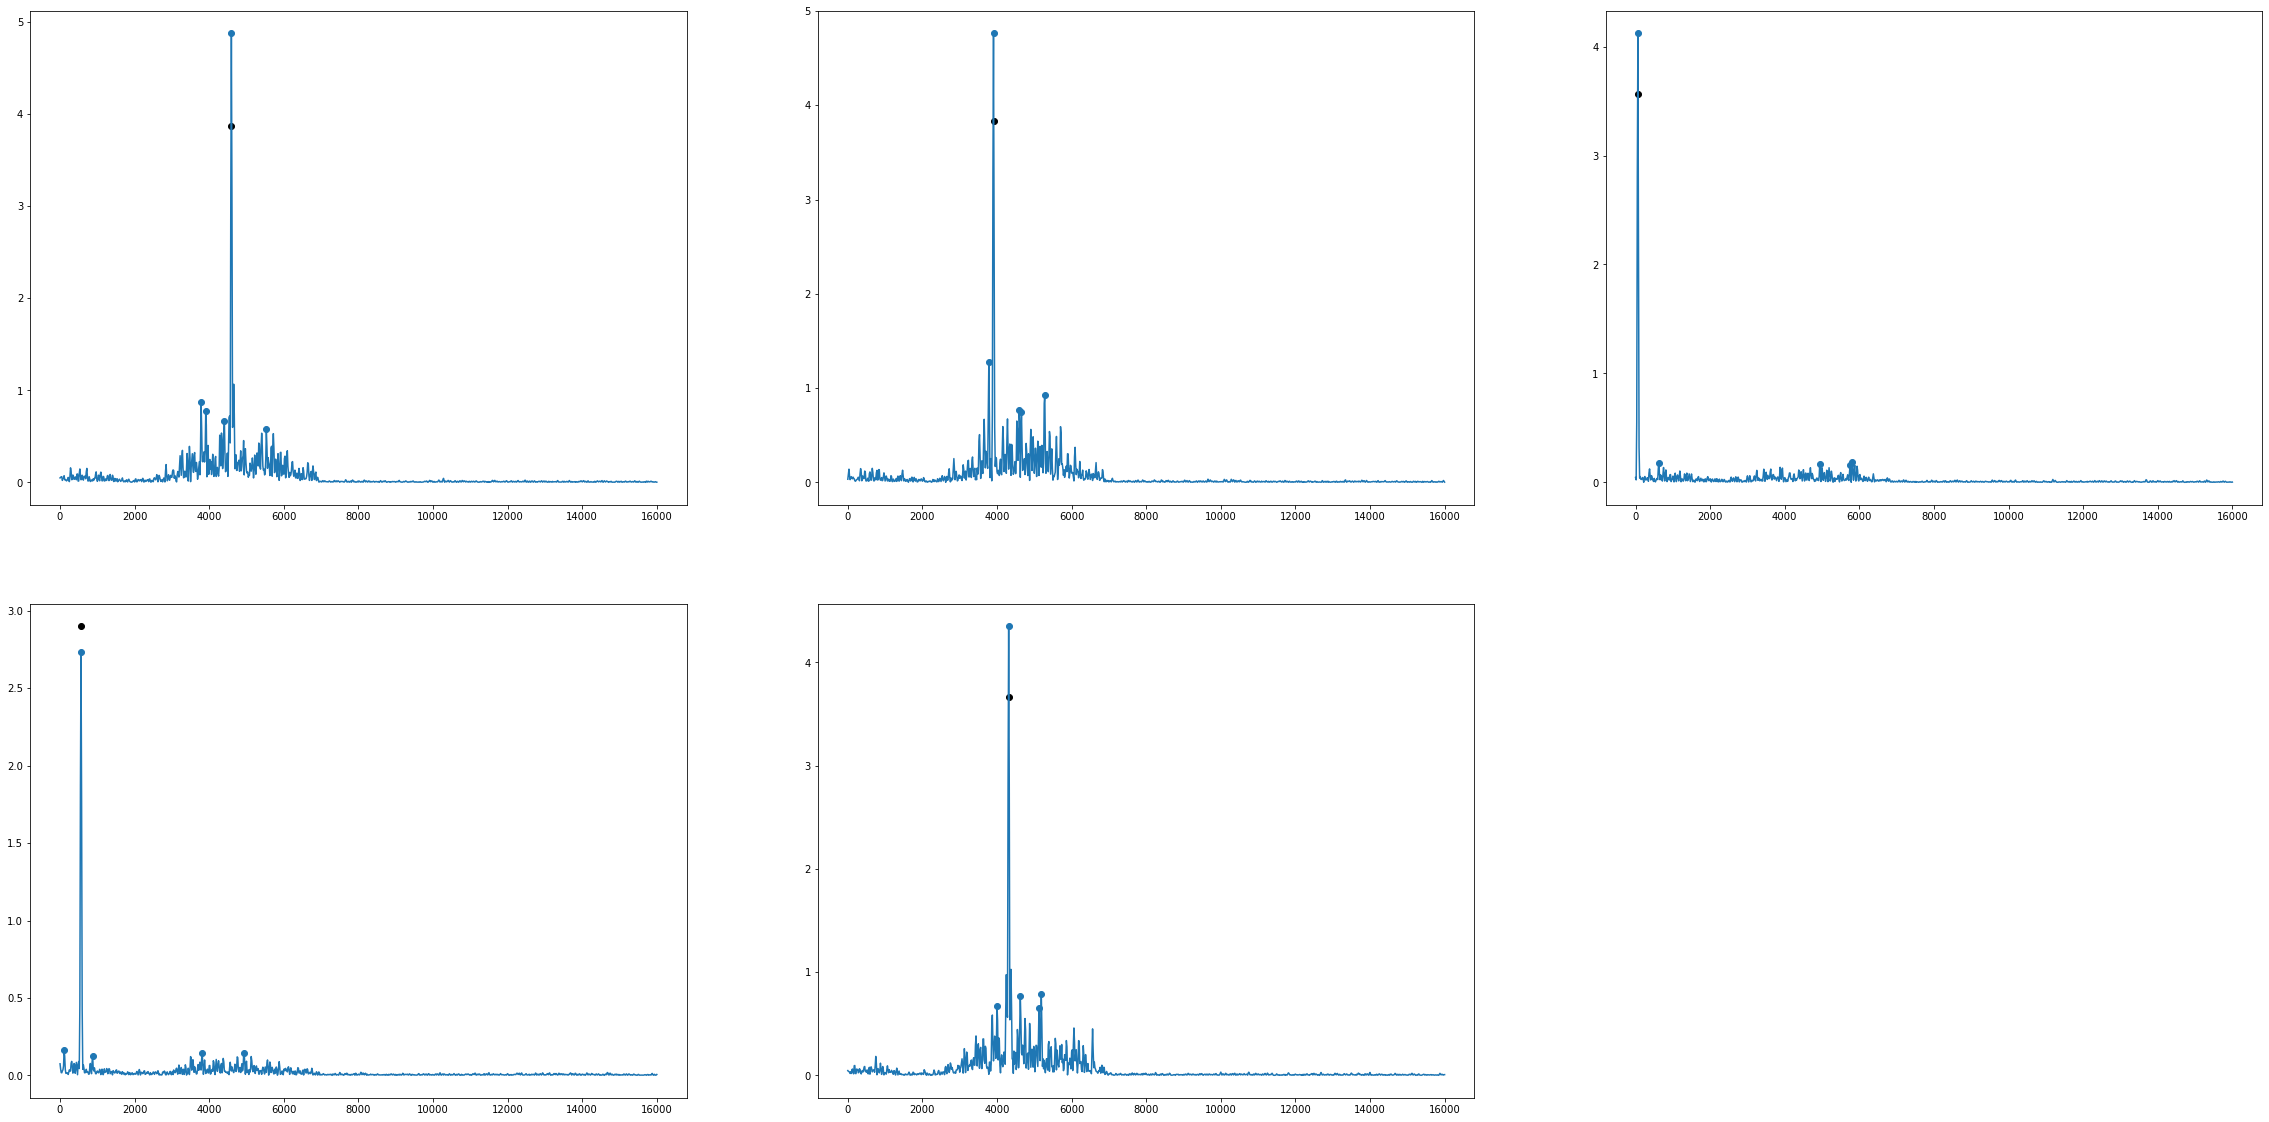

In [746]:
subplot_index = 231

Xcov = np.cov(X)
plt.figure(figsize=(40,20))
for index,peak_index in enumerate(iter_feat['indexes']):
    plt.subplot(subplot_index)
    autocorr_col = np.abs(Xcov[peak_index,:])/psdv
    peak_features,iter_feats = sig_peak_finder_internal(autocorr_col,freqs,primary_widths=[100,200])
    plt.scatter(freqs[iter_feats['indexes']],autocorr_col[iter_feats['indexes']])
    plt.plot(freqs,autocorr_col)
    plt.scatter(freqs[peak_index],psd[peak_index]/psdv,c='k')
    subplot_index +=1

In [740]:
pd.DataFrame(output_spectral_peaks(audio_clips[10]),index=[0])

peak0_freqency  peak0_prominence  peak0_width  peak0_accuracy  \
0        4984.375          5.853375     7.083529         0.43531   

   peak0_width_height  peak1_freqency  peak1_prominence  peak1_width  \
0             3.03487        5765.625          3.761017     3.744606   

   peak1_accuracy  peak1_width_height  ...  peak4_autocorr1_freqency  \
0        0.732949             2.88933  ...                    531.25   

   peak4_autocorr1_prominence  peak4_autocorr1_width  \
0                    3.779709               2.261196   

   peak4_autocorr1_accuracy  peak4_autocorr1_width_height  \
0                  0.557756                      2.479253   

   peak4_autocorr2_freqency  peak4_autocorr2_prominence  \
0                    156.25                     3.08358   

   peak4_autocorr2_width  peak4_autocorr2_accuracy  \
0               2.337248                  0.572146   

   peak4_autocorr2_width_height  
0                       1.89531  

[1 rows x 100 columns]

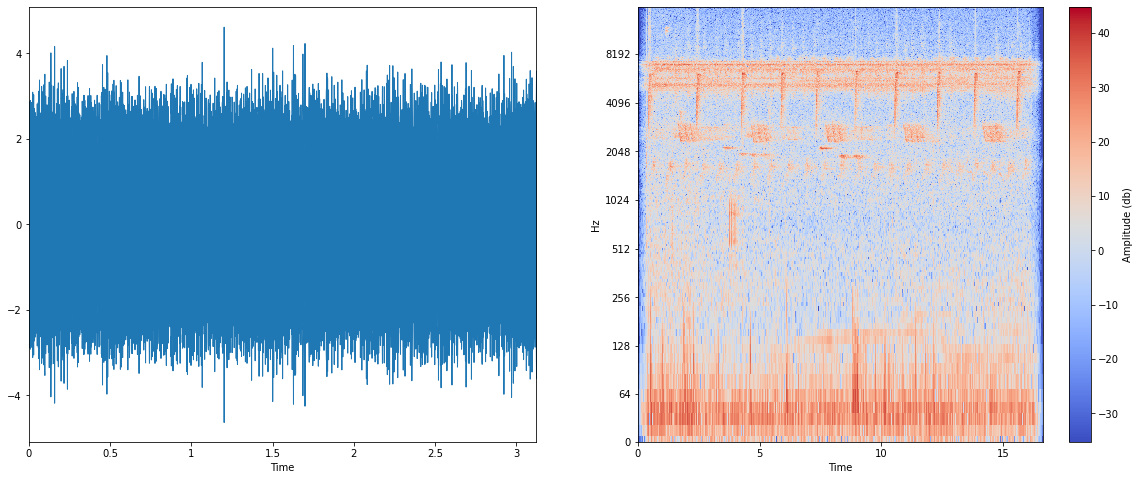

In [265]:
wave_fourier_display(x,X,sr)
ipd.Audio(x,rate=sr)

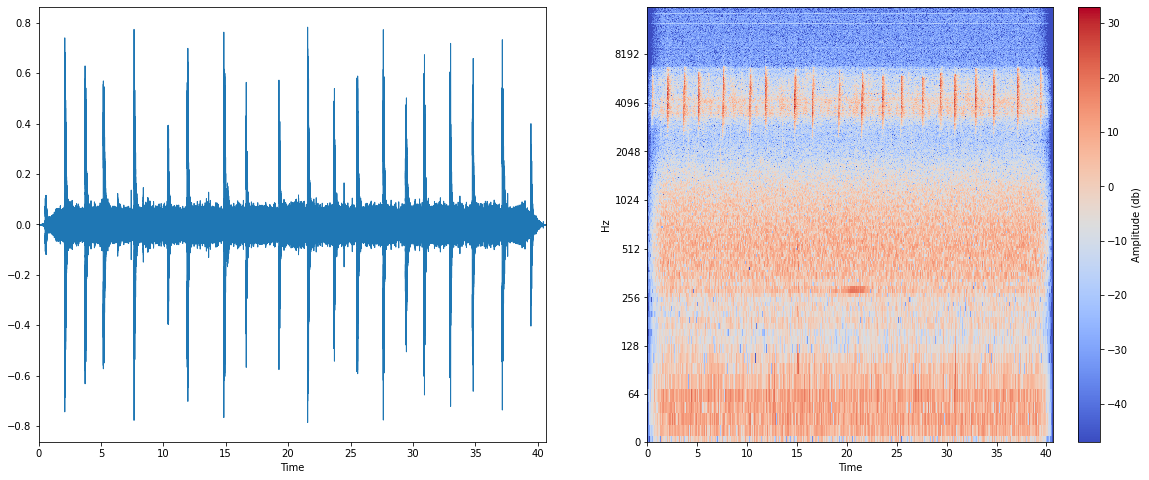

In [709]:
xp,Xp,sr = whiten_invert(X)
wave_fourier_display(xp,Xp,sr)
ipd.Audio(xp/xp.max(),rate=sr)

In [ ]:
plot_compare_PSD(X,Xp,freqs)